In [ ]:
from types import SimpleNamespace

In [ ]:
pip install fastprogress

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys
sys.path.append('/home/user/.local/lib/python3.8/site-packages')
from fastprogress import progress_bar


In [ ]:
pip install wandb

In [ ]:
import wandb, torch

In [ ]:
pip install fastdownload

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Helper functions

In [ ]:
import os, random
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader



def one_batch(dl):
    return next(iter(dl))


def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)





## Architecture of the model

### EMA (Exponential Moving Average) model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

### Creating Unet_conditional model

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)


        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=one_param(self).device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)


class UNet_conditional(UNet):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        return self.unet_forwad(x, t)

### Setting training class

In [ ]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import torch.nn as nn
import numpy as np
from fastprogress import progress_bar

import wandb

import os
import urllib.request
import tarfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # Import tqdm for progress bar

config = SimpleNamespace(
    run_name = "DDPM_conditional",
    epochs = 100,
    noise_steps=1000,
    seed = 42,
    batch_size = 10,
    img_size = 64,
    num_classes = 10,
    train_folder = "train",
    val_folder = "test",
    device = "cuda",
    slice_size = 1,
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10,
    lr = 5e-3)


logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")


class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, num_classes=10, c_in=3, c_out=3, device="cuda", **kwargs):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet_conditional(c_in, c_out, num_classes=num_classes, **kwargs).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
        self.num_classes = num_classes

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    @torch.inference_mode()
    def sample(self, use_ema, labels, cfg_scale=3):
        model = self.ema_model if use_ema else self.model
        n = len(labels)
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x





    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: self.model.train()
        else: self.model.eval()
        pbar = progress_bar(self.train_dataloader, leave=False)

        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                labels = torch.tensor(labels)
                images = images.to(self.device)
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
                wandb.log({"train_mse": loss.item(),
                            "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"MSE={loss.item():2.3f}"
        return avg_loss.mean().item()

    def log_images(self):
        "Log images to wandb and save them to disk"

        labels = torch.arange(self.num_classes).long().to(self.device)
        sampled_images = self.sample(use_ema=False, labels=labels)
        wandb.log({"sampled_images":     [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in sampled_images]})

        # EMA model sampling
        ema_sampled_images = self.sample(use_ema=True, labels=labels)
        plot_images(sampled_images)  #to display on jupyter if available
        wandb.log({"ema_sampled_images": [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in ema_sampled_images]})
        plot_images(ema_sampled_images)  #to display on jupyter if available

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

    def save_model(self, run_name, epoch=-1):
        "Save model locally and on wandb"
        torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
        at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
        at.add_dir(os.path.join("models", run_name))
        wandb.log_artifact(at)



    def f(batch_size=128):
        dataset_url = "https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz"
        dataset_path = "cifar10.tgz"
        extracted_folder = "cifar10"

        if not os.path.exists(dataset_path):
            urllib.request.urlretrieve(dataset_url, dataset_path)

        if not os.path.exists(extracted_folder):
            with tarfile.open(dataset_path, "r:gz") as tar:
                tar.extractall()

        train_transforms = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])

        train_dataset = datasets.ImageFolder(os.path.join(extracted_folder, 'train'), transform=train_transforms)

        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

        data_iter = iter(train_loader)
        images, labels = next(data_iter)

        return train_loader


    def prepare(self, args):

        self.train_dataloader = self.f()

        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr,
                                                 steps_per_epoch=len(self.train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()

    def fit(self, args):
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            logging.info(f"Starting epoch {epoch}:")
            _  = self.one_epoch(train=True)

            ## validation
            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
                wandb.log({"val_mse": avg_loss})

            # log predicitons
            if epoch % args.log_every_epoch == 0:
                self.log_images()

        # save model
        self.save_model(run_name=args.run_name, epoch=epoch)




def parse_args(config):
    parser = argparse.ArgumentParser(description='Process hyper-parameters')
    parser.add_argument('--run_name', type=str, default=config.run_name, help='name of the run')
    parser.add_argument('--epochs', type=int, default=config.epochs, help='number of epochs')
    parser.add_argument('--seed', type=int, default=config.seed, help='random seed')
    parser.add_argument('--batch_size', type=int, default=config.batch_size, help='batch size')
    parser.add_argument('--img_size', type=int, default=config.img_size, help='image size')
    parser.add_argument('--num_classes', type=int, default=config.num_classes, help='number of classes')
    parser.add_argument('--device', type=str, default=config.device, help='device')
    parser.add_argument('--lr', type=float, default=config.lr, help='learning rate')
    parser.add_argument('--slice_size', type=int, default=config.slice_size, help='slice size')
    parser.add_argument('--noise_steps', type=int, default=config.noise_steps, help='noise steps')
    args = vars(parser.parse_args())

    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)


if __name__ == '__main__':
    parse_args(config)

    ## seed everything
    diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
    with wandb.init(project="train_sd", group="train", config=config):
        diffuser.prepare(config)
        diffuser.fit(config)


usage: ipykernel_launcher.py [-h] [--run_name RUN_NAME] [--epochs EPOCHS]
                             [--seed SEED] [--batch_size BATCH_SIZE]
                             [--img_size IMG_SIZE] [--num_classes NUM_CLASSES]
                             [--device DEVICE] [--lr LR]
                             [--slice_size SLICE_SIZE]
                             [--noise_steps NOISE_STEPS]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/user/.local/share/jupyter/runtime/kernel-368eeb1e-c57f-4bc6-a4de-82058d4b591b.json


SystemExit: 2

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Setting parameters for training model

In [ ]:
import argparse
from pathlib import Path

class Config:
    def __init__(self):
        # Set default values for each attribute
        self.run_name = 'DDPM_conditional'
        self.epochs = 100
        self.noise_steps = 1000
        self.seed = 42
        self.batch_size = 128
        self.img_size = 64
        self.num_classes = 10

        self.device = 'cuda'
        self.slice_size = 1
        self.use_wandb = True
        self.do_validation = False
        self.log_every_epoch = 10
        self.num_workers = 10
        self.lr = 0.0003

    def parse_args(self):
        parser = argparse.ArgumentParser(description='Process hyper-parameters')

        parser.add_argument('--run_name', type=str, default=self.run_name, help='name of the run')
        parser.add_argument('--epochs', type=int, default=self.epochs, help='number of epochs')
        parser.add_argument('--noise_steps', type=int, default=self.noise_steps, help='noise steps')
        parser.add_argument('--seed', type=int, default=self.seed, help='random seed')
        parser.add_argument('--batch_size', type=int, default=self.batch_size, help='batch size')
        parser.add_argument('--img_size', type=int, default=self.img_size, help='image size')
        parser.add_argument('--num_classes', type=int, default=self.num_classes, help='number of classes')

        parser.add_argument('--device', type=str, default=self.device, help='device')
        parser.add_argument('--slice_size', type=int, default=self.slice_size, help='slice size')
        parser.add_argument('--use_wandb', type=bool, default=self.use_wandb, help='use Weights & Biases')
        parser.add_argument('--do_validation', type=bool, default=self.do_validation, help='perform validation')
        parser.add_argument('--log_every_epoch', type=int, default=self.log_every_epoch, help='logging interval')
        parser.add_argument('--num_workers', type=int, default=self.num_workers, help='number of workers')
        parser.add_argument('--lr', type=float, default=self.lr, help='learning rate')

        args, _ = parser.parse_known_args()

        for key, value in vars(args).items():
            setattr(self, key, value)

    def __repr__(self):
        return f"Config({', '.join([f'{k}={v}' for k, v in self.__dict__.items()])})"

# Example usage
config = Config()
config.parse_args()
print(config)


Config(run_name=DDPM_conditional, epochs=100, noise_steps=1000, seed=42, batch_size=128, img_size=64, num_classes=10, device=cuda, slice_size=1, use_wandb=True, do_validation=False, log_every_epoch=10, num_workers=10, lr=0.0003)


## Performing training:

wandb: Currently logged in as: abdurahmon_a (abdurahmon_a-innopolis-university). Use `wandb login --relogin` to force relogin


11:17:04 - INFO: Starting epoch 0:


/tmp/ipykernel_4081/130008081.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
11:18:37 - INFO: Sampling 10 new images....


11:19:59 - INFO: Sampling 10 new images....


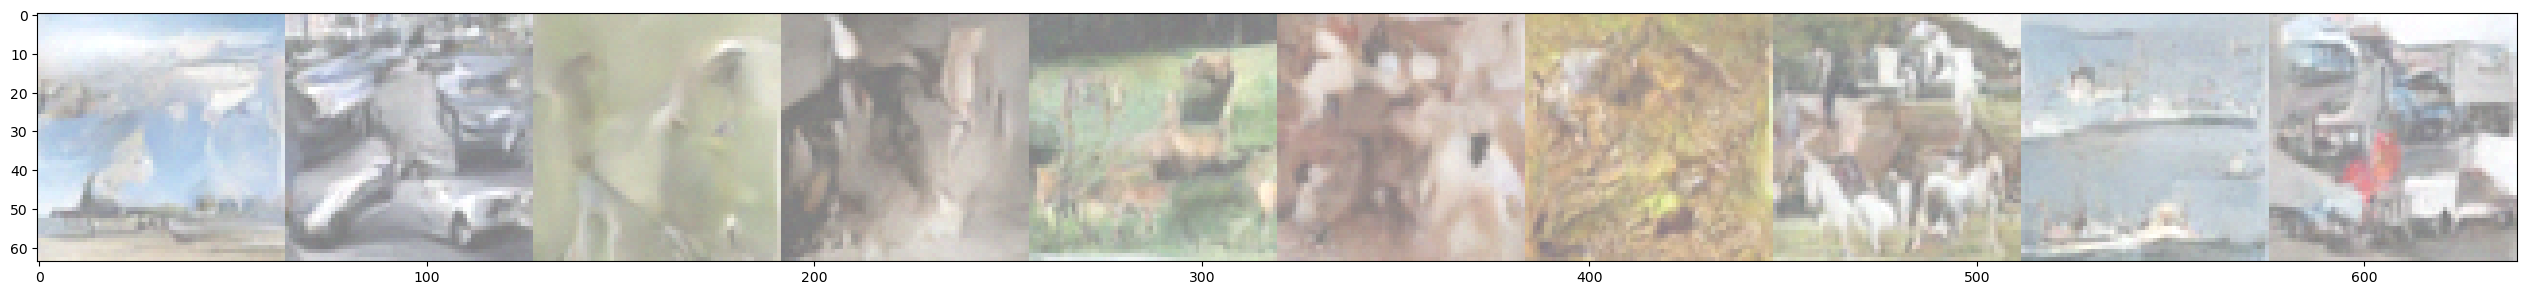

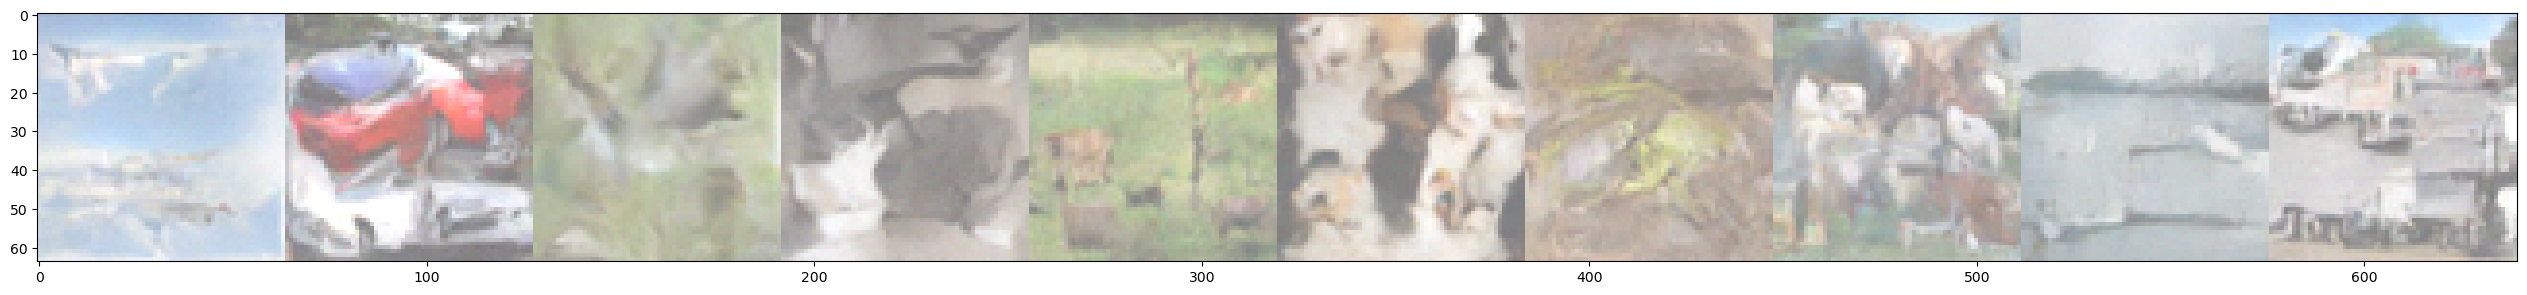

11:21:22 - INFO: Starting epoch 1:


11:22:55 - INFO: Starting epoch 2:


11:24:27 - INFO: Starting epoch 3:


11:26:00 - INFO: Starting epoch 4:


11:27:33 - INFO: Starting epoch 5:


11:29:06 - INFO: Starting epoch 6:


11:30:37 - INFO: Starting epoch 7:


11:32:10 - INFO: Starting epoch 8:


11:33:42 - INFO: Starting epoch 9:


11:35:14 - INFO: Starting epoch 10:


11:36:47 - INFO: Sampling 10 new images....


11:38:08 - INFO: Sampling 10 new images....


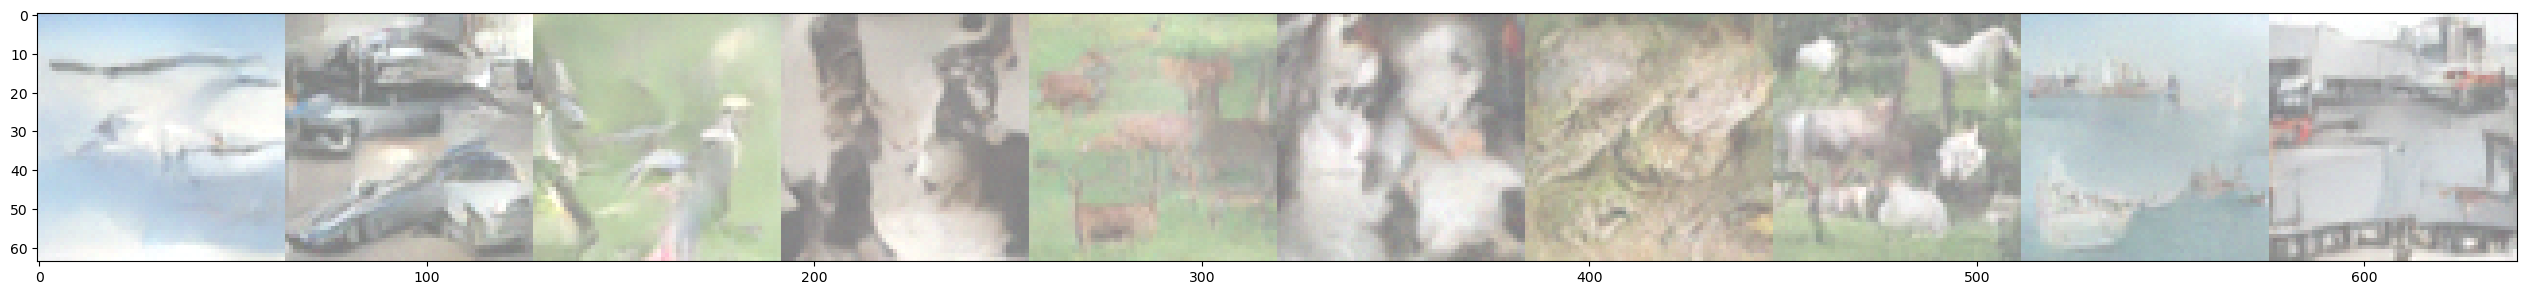

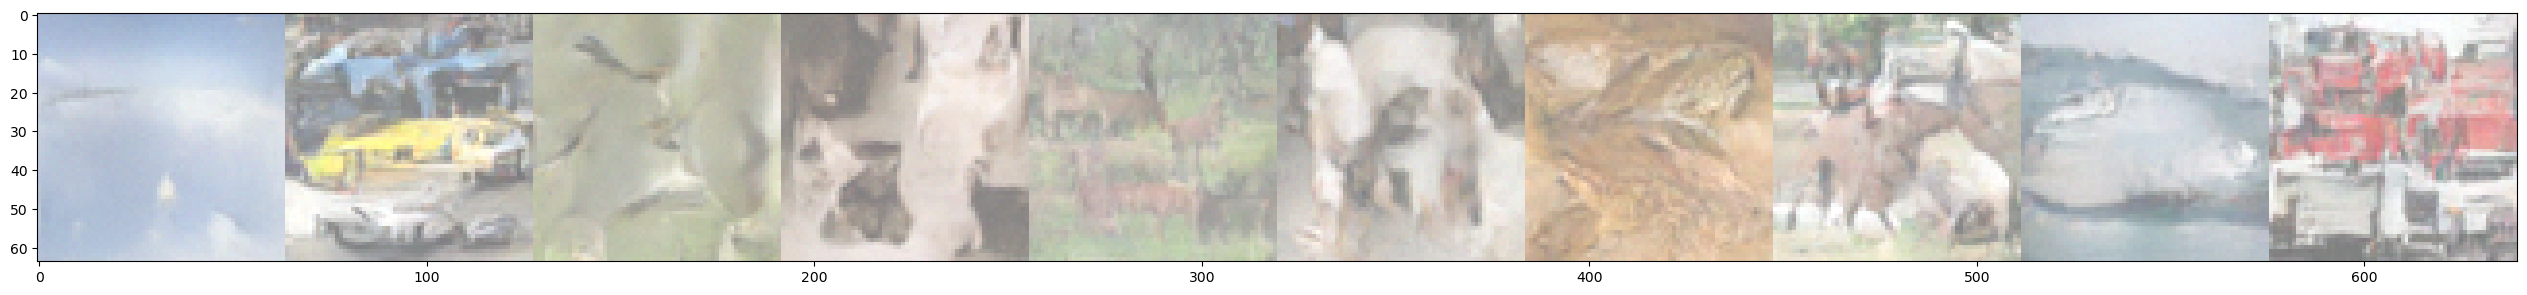

11:39:31 - INFO: Starting epoch 11:


11:41:03 - INFO: Starting epoch 12:


11:42:36 - INFO: Starting epoch 13:


11:44:08 - INFO: Starting epoch 14:


11:45:42 - INFO: Starting epoch 15:


11:47:11 - INFO: Starting epoch 16:


11:48:40 - INFO: Starting epoch 17:


11:50:08 - INFO: Starting epoch 18:


11:51:35 - INFO: Starting epoch 19:


11:53:03 - INFO: Starting epoch 20:


11:54:31 - INFO: Sampling 10 new images....


11:55:52 - INFO: Sampling 10 new images....


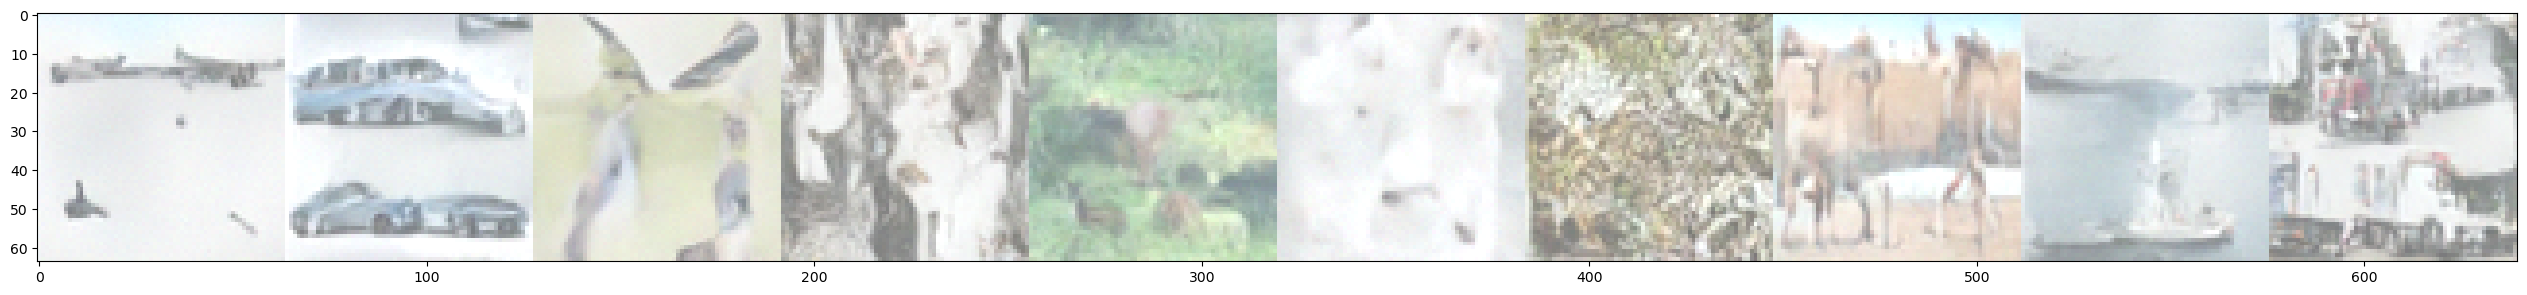

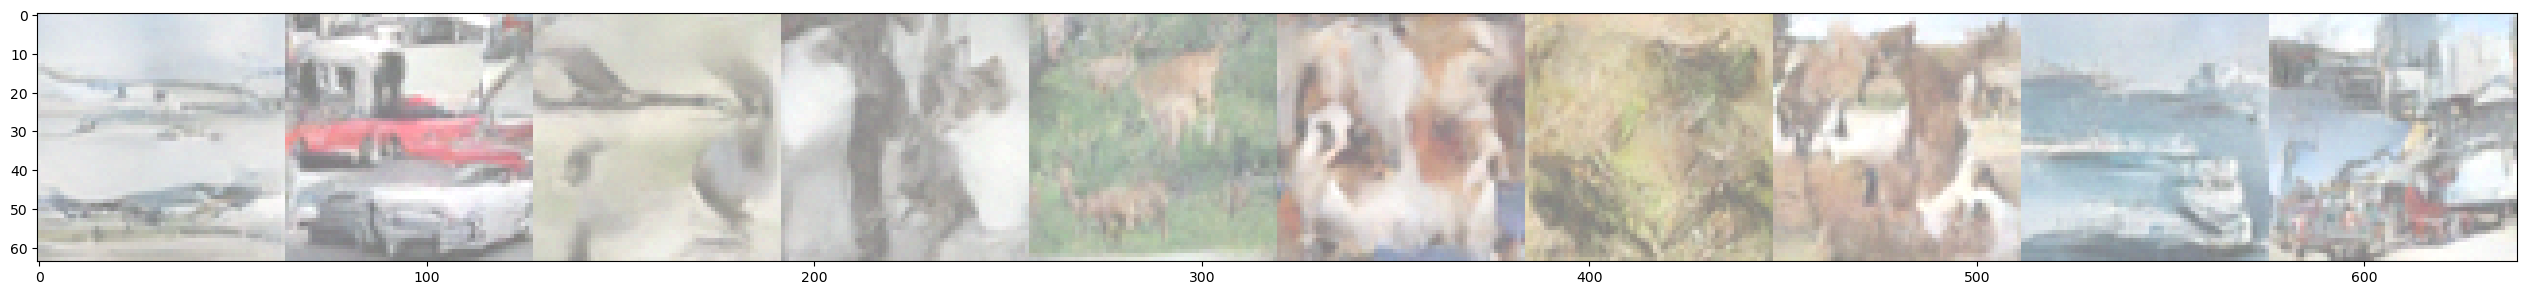

11:57:14 - INFO: Starting epoch 21:


11:58:42 - INFO: Starting epoch 22:


12:00:09 - INFO: Starting epoch 23:


12:01:37 - INFO: Starting epoch 24:


12:03:05 - INFO: Starting epoch 25:


12:04:33 - INFO: Starting epoch 26:


12:06:01 - INFO: Starting epoch 27:


12:07:29 - INFO: Starting epoch 28:


12:08:57 - INFO: Starting epoch 29:


12:10:25 - INFO: Starting epoch 30:


12:11:53 - INFO: Sampling 10 new images....


12:13:14 - INFO: Sampling 10 new images....


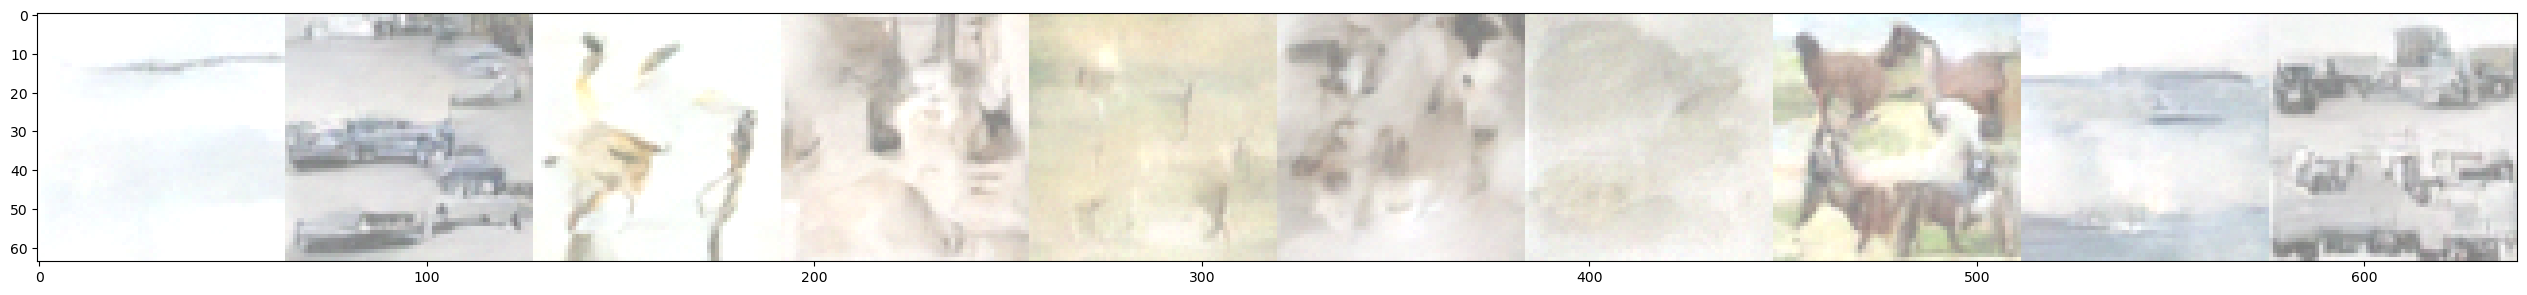

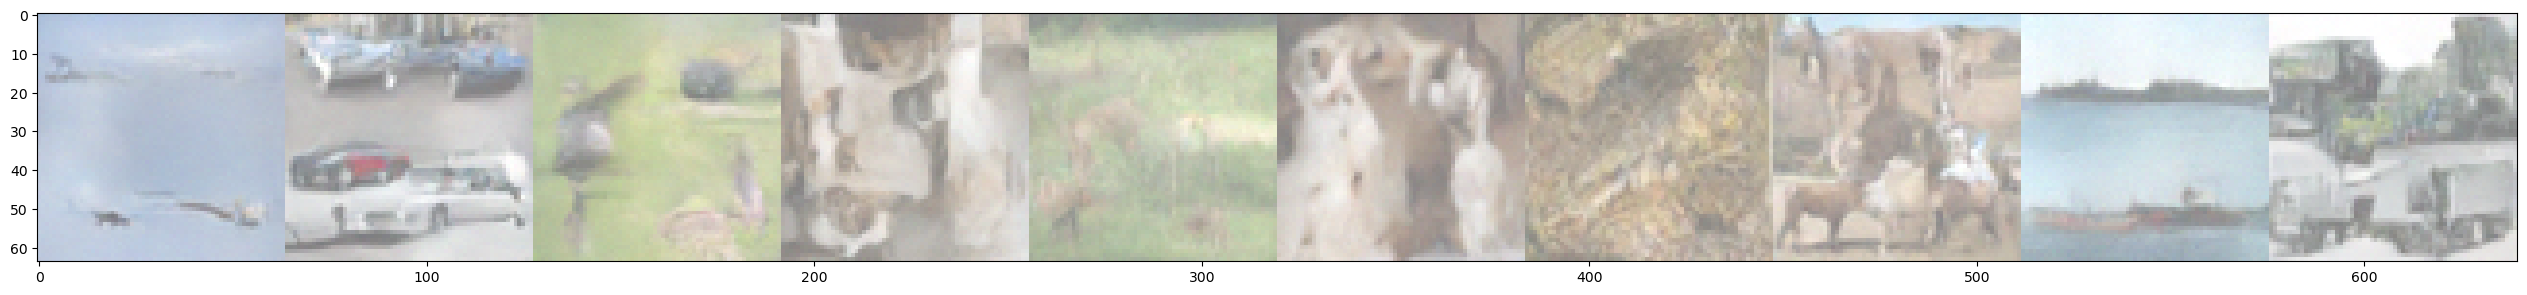

12:14:36 - INFO: Starting epoch 31:


12:16:04 - INFO: Starting epoch 32:


12:17:32 - INFO: Starting epoch 33:


12:18:59 - INFO: Starting epoch 34:


12:20:28 - INFO: Starting epoch 35:


12:21:55 - INFO: Starting epoch 36:


12:23:23 - INFO: Starting epoch 37:


12:24:51 - INFO: Starting epoch 38:


12:26:19 - INFO: Starting epoch 39:


12:27:47 - INFO: Starting epoch 40:


12:29:15 - INFO: Sampling 10 new images....


12:30:36 - INFO: Sampling 10 new images....


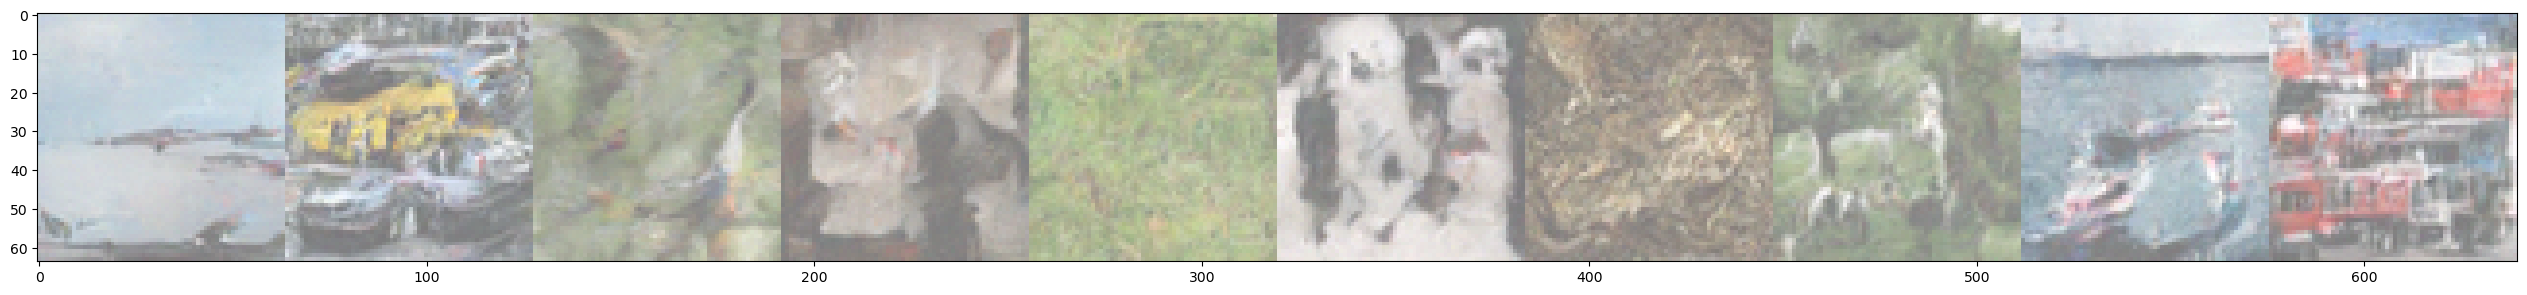

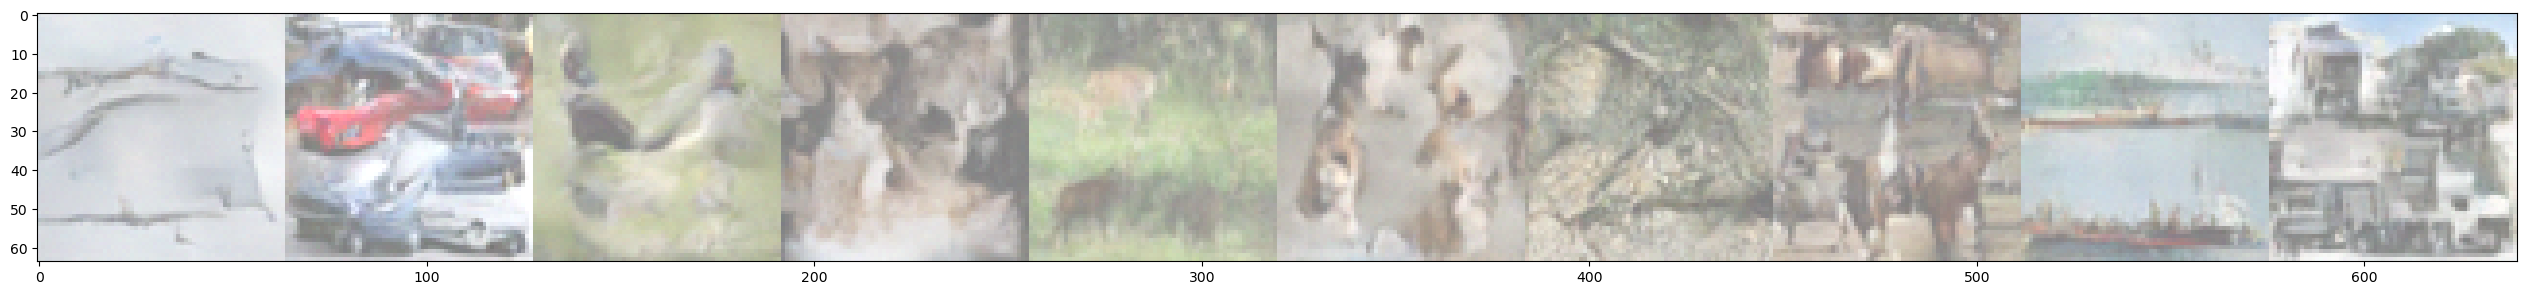

12:31:58 - INFO: Starting epoch 41:


12:33:26 - INFO: Starting epoch 42:


12:34:54 - INFO: Starting epoch 43:


12:36:22 - INFO: Starting epoch 44:


12:37:50 - INFO: Starting epoch 45:


12:39:18 - INFO: Starting epoch 46:


12:40:46 - INFO: Starting epoch 47:


12:42:14 - INFO: Starting epoch 48:


12:43:42 - INFO: Starting epoch 49:


12:45:10 - INFO: Starting epoch 50:


12:46:38 - INFO: Sampling 10 new images....


12:47:59 - INFO: Sampling 10 new images....


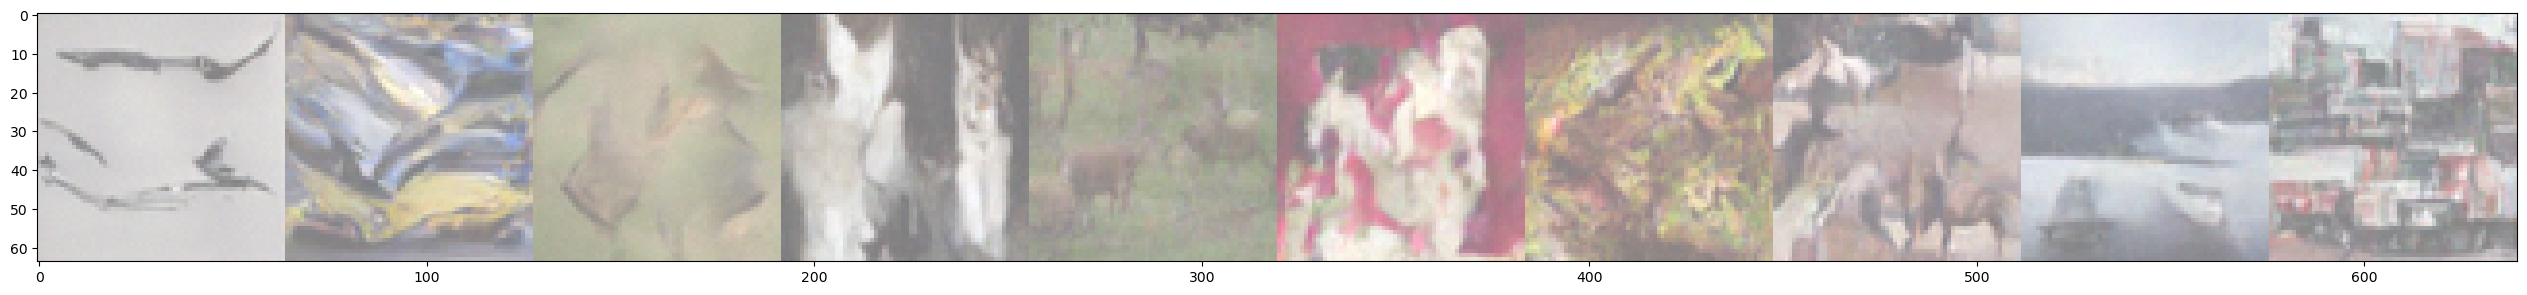

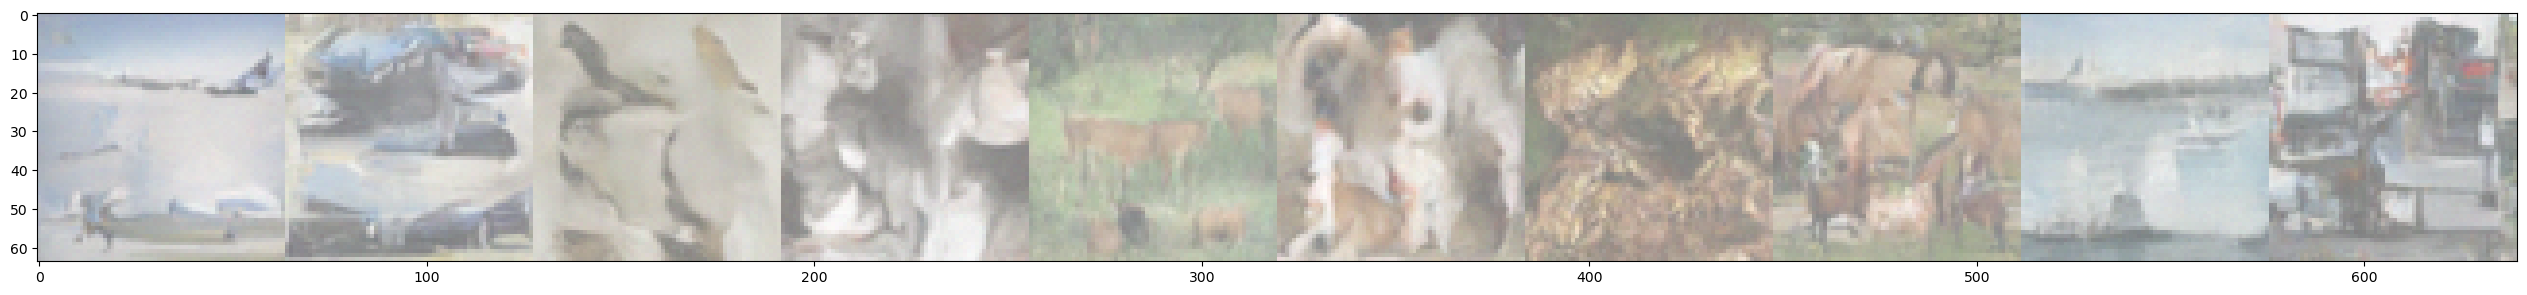

12:49:21 - INFO: Starting epoch 51:


12:50:49 - INFO: Starting epoch 52:


12:52:17 - INFO: Starting epoch 53:


12:53:45 - INFO: Starting epoch 54:


12:55:13 - INFO: Starting epoch 55:


12:56:41 - INFO: Starting epoch 56:


12:58:09 - INFO: Starting epoch 57:


12:59:37 - INFO: Starting epoch 58:


01:01:05 - INFO: Starting epoch 59:


01:02:33 - INFO: Starting epoch 60:


01:04:01 - INFO: Sampling 10 new images....


01:05:22 - INFO: Sampling 10 new images....


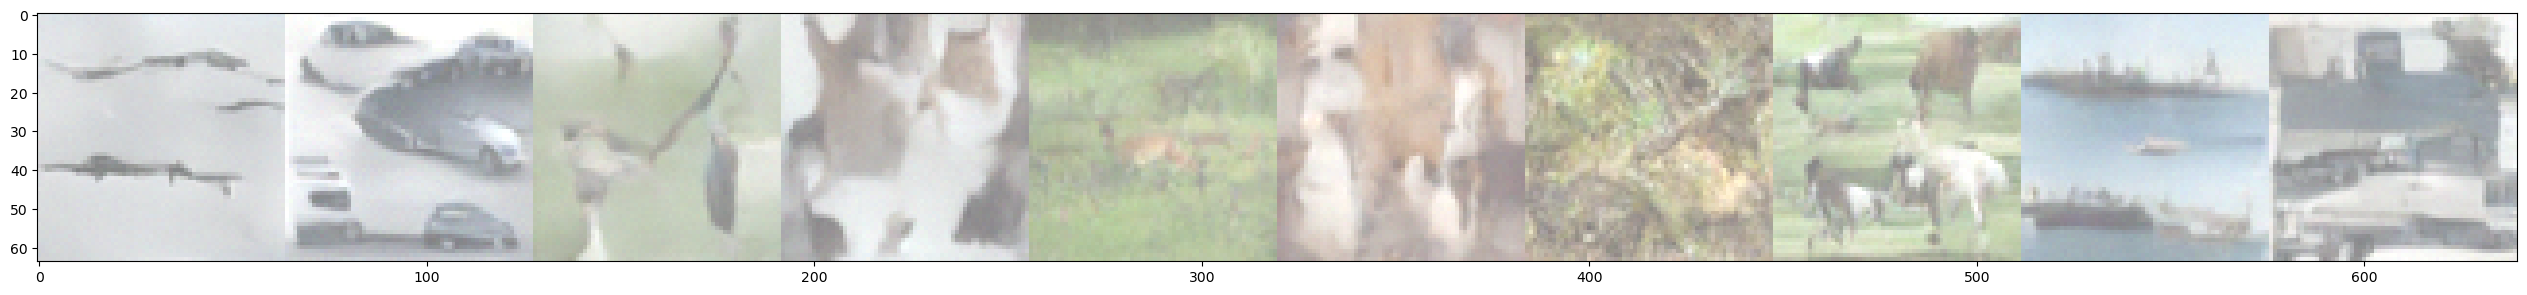

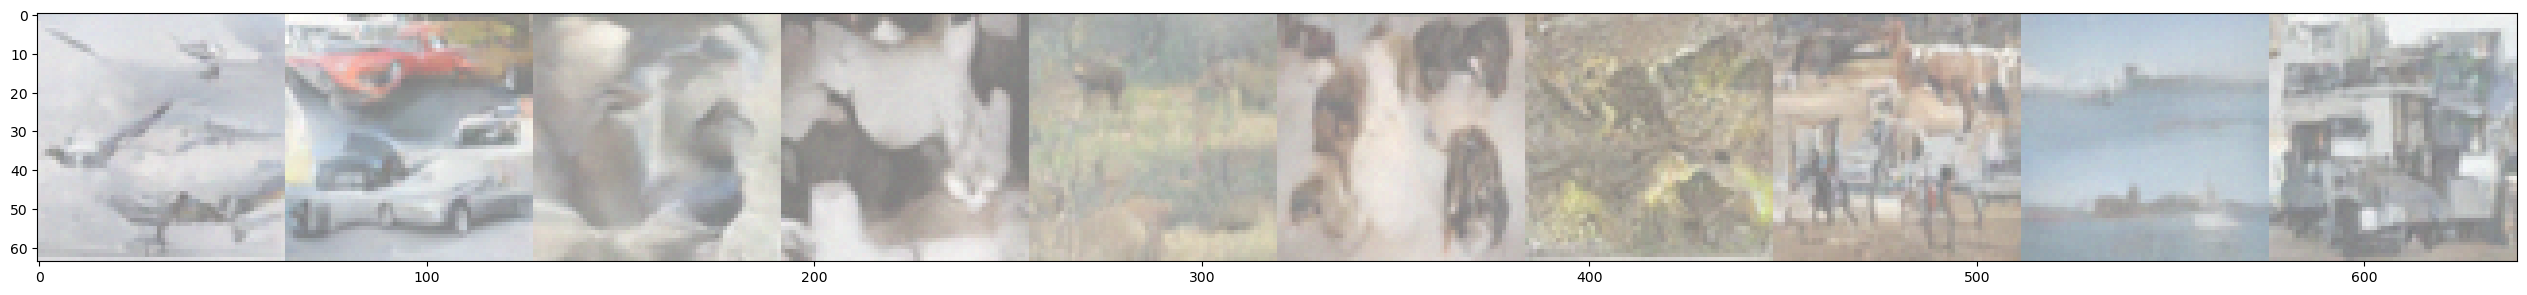

01:06:44 - INFO: Starting epoch 61:


01:08:12 - INFO: Starting epoch 62:


01:09:40 - INFO: Starting epoch 63:


01:11:09 - INFO: Starting epoch 64:


01:12:36 - INFO: Starting epoch 65:


01:14:04 - INFO: Starting epoch 66:


01:15:33 - INFO: Starting epoch 67:


01:17:01 - INFO: Starting epoch 68:


01:18:29 - INFO: Starting epoch 69:


01:19:56 - INFO: Starting epoch 70:


01:21:24 - INFO: Sampling 10 new images....


01:22:45 - INFO: Sampling 10 new images....


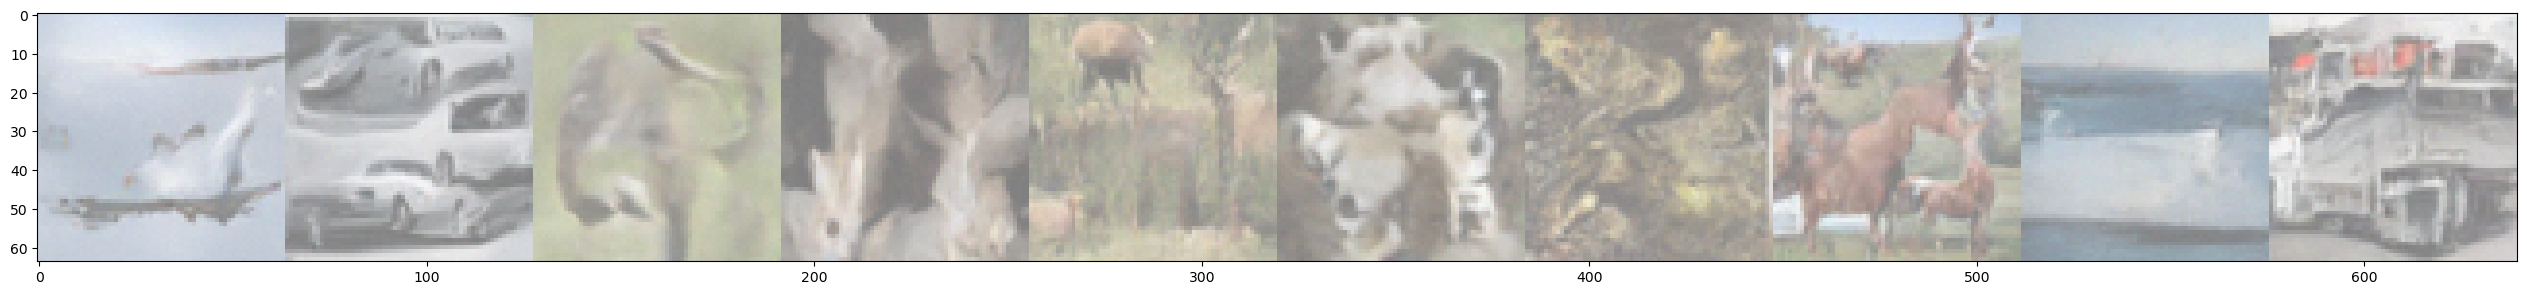

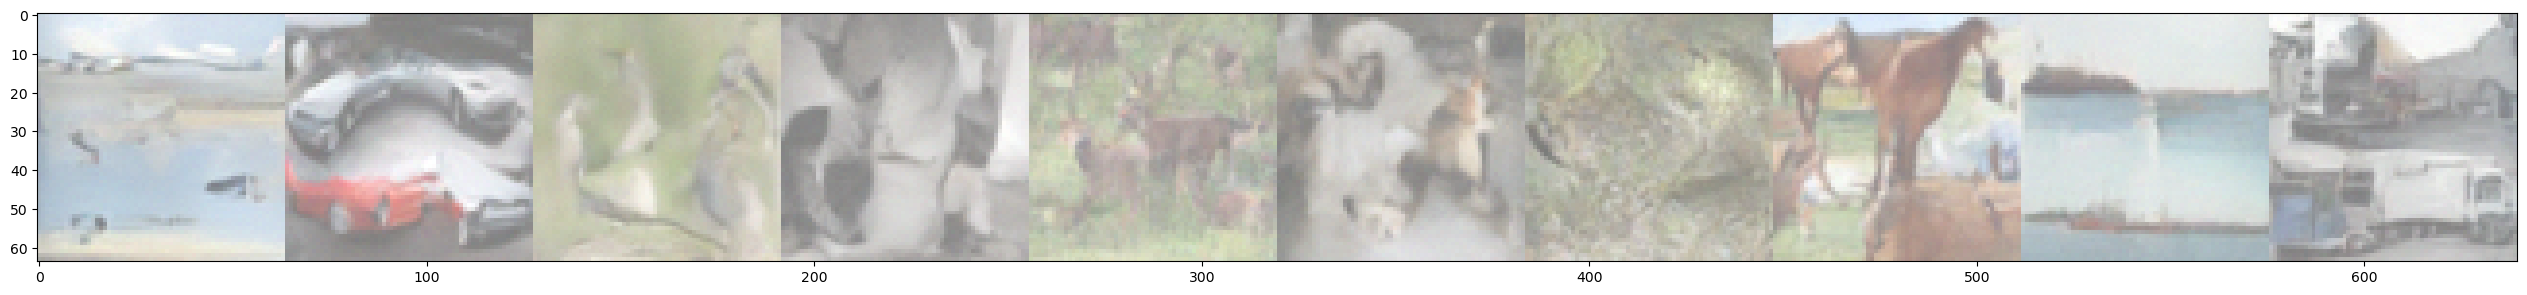

01:24:07 - INFO: Starting epoch 71:


01:25:36 - INFO: Starting epoch 72:


01:27:04 - INFO: Starting epoch 73:


01:28:32 - INFO: Starting epoch 74:


01:30:01 - INFO: Starting epoch 75:


01:31:29 - INFO: Starting epoch 76:


01:32:57 - INFO: Starting epoch 77:


01:34:25 - INFO: Starting epoch 78:


01:35:53 - INFO: Starting epoch 79:


01:37:21 - INFO: Starting epoch 80:


01:38:50 - INFO: Sampling 10 new images....


01:40:11 - INFO: Sampling 10 new images....


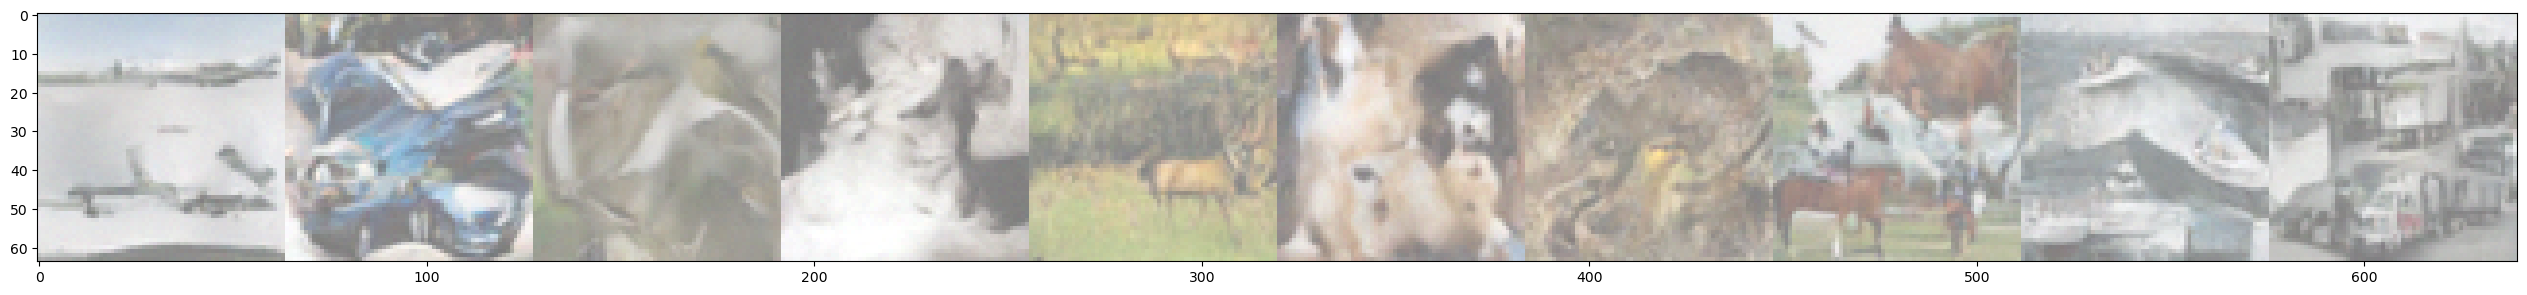

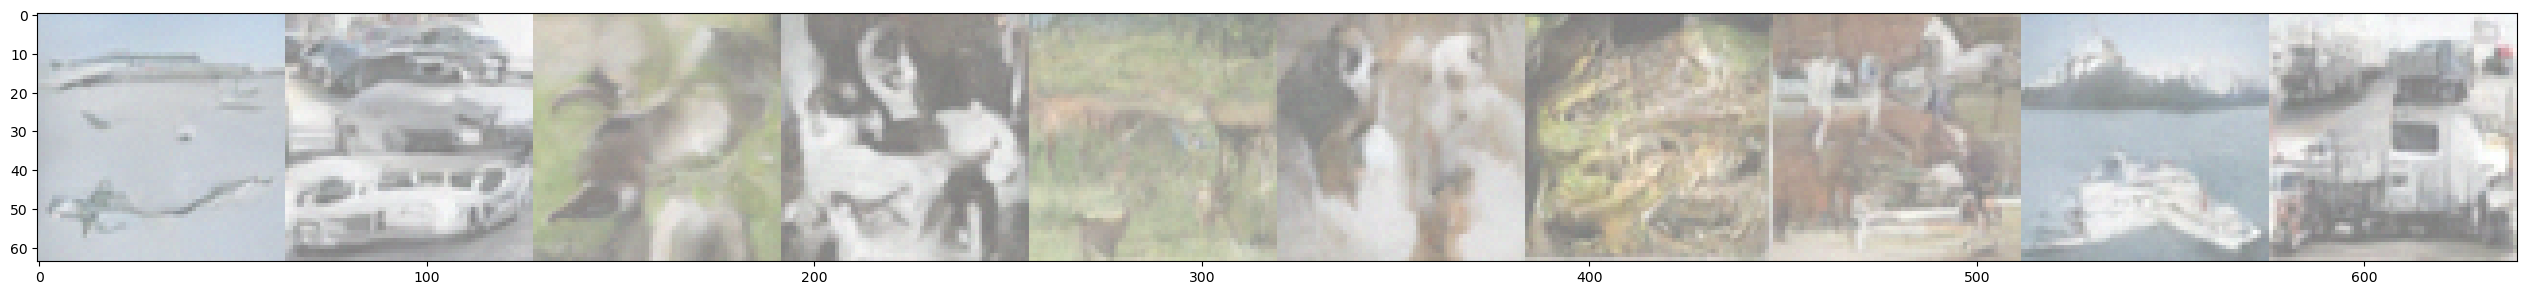

01:41:33 - INFO: Starting epoch 81:


01:43:01 - INFO: Starting epoch 82:


01:44:29 - INFO: Starting epoch 83:


01:45:57 - INFO: Starting epoch 84:


01:47:25 - INFO: Starting epoch 85:


01:48:52 - INFO: Starting epoch 86:


01:50:20 - INFO: Starting epoch 87:


01:51:48 - INFO: Starting epoch 88:


01:53:16 - INFO: Starting epoch 89:


01:54:44 - INFO: Starting epoch 90:


01:56:12 - INFO: Sampling 10 new images....


01:57:32 - INFO: Sampling 10 new images....


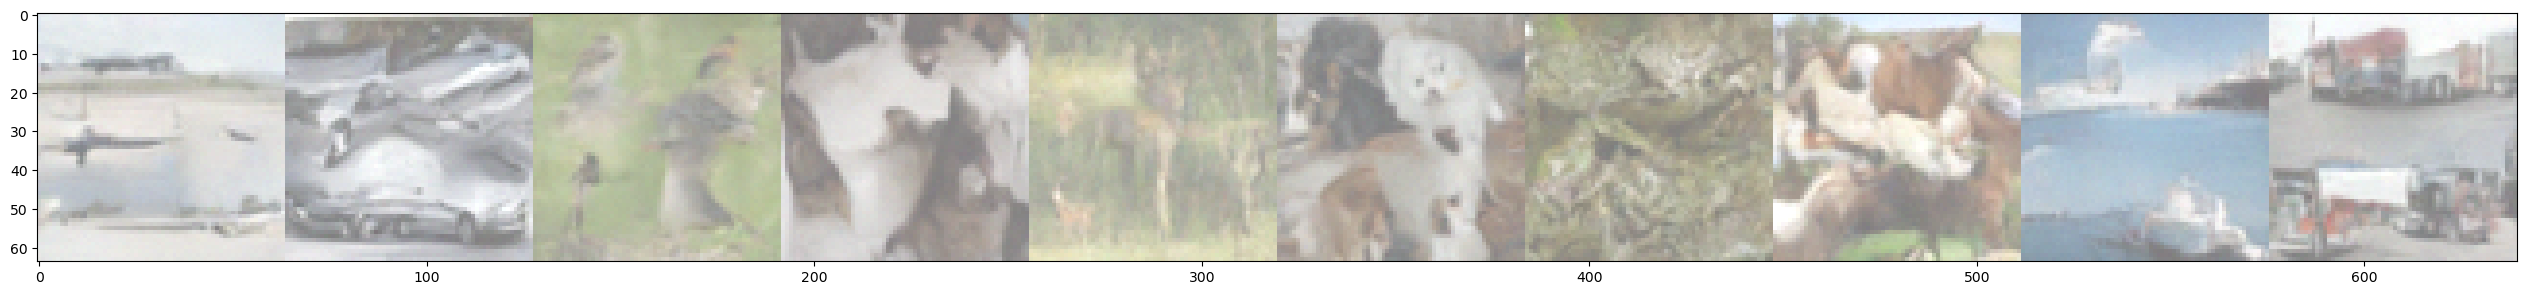

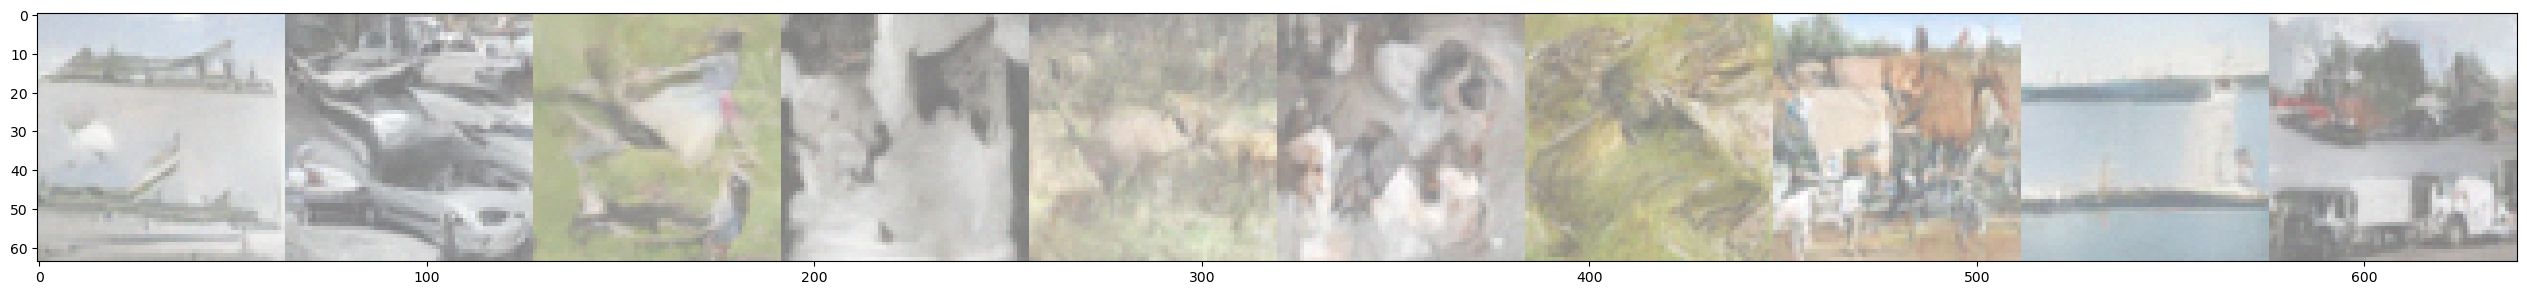

01:58:54 - INFO: Starting epoch 91:


02:00:22 - INFO: Starting epoch 92:


02:01:50 - INFO: Starting epoch 93:


02:03:18 - INFO: Starting epoch 94:


02:04:46 - INFO: Starting epoch 95:


02:06:14 - INFO: Starting epoch 96:


02:07:41 - INFO: Starting epoch 97:


02:09:10 - INFO: Starting epoch 98:


02:10:37 - INFO: Starting epoch 99:


Traceback (most recent call last):
  File "/tmp/ipykernel_4081/1360116313.py", line 12, in <module>
    diffuser.fit(config)
  File "/tmp/ipykernel_4081/130008081.py", line 216, in fit
    self.save_model(run_name=args.run_name, epoch=epoch)
  File "/tmp/ipykernel_4081/130008081.py", line 154, in save_model
    torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 440, in save
    with _open_zipfile_writer(f) as opened_zipfile:
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 315, in _open_zipfile_writer
    return container(name_or_buffer)
  File "/usr/lib/python3/dist-packages/torch/serialization.py", line 288, in __init__
    super().__init__(torch._C.PyTorchFileWriter(str(name)))
RuntimeError: Parent directory models/DDPM_conditional does not exist.


learning_rate,▁▂▂▂▂▄▄▄▅▇▇▇█████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁
train_mse,▂▄▂▂▃▂▄▄▃▁▂▅▅▂▄▃▄▅▂▃▄▄▁▅▁▃▃▂▂▂▄▄▄▄▃▂▅▃█▄
learning_rate,0.0
train_mse,0.01973


RuntimeError: Parent directory models/DDPM_conditional does not exist.

In [ ]:
def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))




diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
with wandb.init(project="train_sd", group="train", config=config):
    diffuser.prepare(config)
    diffuser.load('')
    diffuser.fit(config)